## Introduction

Sept 2021

Going to analyse all the IP21 tags for AL6 (packaging) 

Import some libraries

In [1]:
import configparser

Config = configparser.ConfigParser()

Config.read('settings.cfg')

def ConfigSectionMap(section):
    dict1 = {}
    options = Config.options(section)
    for option in options:
        try:
            dict1[option] = Config.get(section, option)
            if dict1[option] == -1:
                DebugPrint("skip: %s" % option)
        except:
            print("exception on %s!" % option)
            dict1[option] = None
    return dict1



dir_sanofi_share = ConfigSectionMap("SectionOne")['sanofi']
dir_local = ConfigSectionMap("SectionOne")['local']

print ("dir_sanofi_share is %s" % (dir_sanofi_share))
print ("dir_local is %s" % (dir_local))


dir_sanofi_share is C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Frankfurt sprint/SFD/
dir_local is C:/Users/mark_/Documents/McLaren2021/Sanofi/


In [2]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt


## tabIP21Tags.csv

This looks like a summary file created by Marco's process.  Don't read this in with the other csv files, but we might want to merge in some of this information, like DEFINITION




|Name|DEFINITION|IP_DESCRIPTION|IP_STEPPED|IP_DC_SIGNIFICANCE|IP_VALUE_FORMAT|IP_ENG_UNITS|IP_HIGH_HIGH_LIMIT|IP_HIGH_LIMIT|IP_LOW_LIMIT|IP_LOW_LOW_LIMIT|IP_PLANT_AREA|IP_REPOSITORY|IP_TAG_TYPE|
|----|----------|--------------|----------|------------------|---------------|------------|------------------|-------------|------------|----------------|-------------|-------------|-----------|
|36630901_CNTRB_ST6|IP_DiscreteAvDef|AL6 HH: Schlechtteile Station 6|Stepped|1|I11|Stck|400000|400000|0|0|AL6|TSK_DHIS_SFD|Discrete|
|36630901_ZA_MATNO|IP_TextAvDef|AL6 HH: ZA Materialnummer|||||||||AL6|TSK_DHIS_SFD|Text|
|36630901_PROD_MODE|IP_TextAvDef|AL6 HH: Produktionsmodus|||||||||AL6|TSK_DHIS_SFD|Text|
|36630901_BATCHACTIVE|IP_DiscreteAvDef|AL6 HH: Batch aktiv|Stepped|1|I 2|-|2|2|0|0|AL6|TSK_DHIS_SFD|Discrete|
|36630901_MATNO|IP_TextAvDef|AL6 HH: Materialnummer|||||||||AL6|TSK_DHIS_SFD|Text|




In [3]:
# read OEE Detailed Events report file for AL6 packaging machines
folder = 'IP21_data'

Files = []
df = []
df_IP21 = pd.DataFrame()

for filename in os.listdir( dir_sanofi_share + folder ):
    if filename.endswith('.csv'):
        if not (filename == 'tabIP21Tags.csv'):
            Files.append(filename)

Files.sort(key=str.lower)

# Loop through all the files.
for filename in Files:
    # ignore WATCH{DOG} files
    if not 'WATCH' in filename:
        path = os.path.join(dir_sanofi_share, folder, filename)
        # print (filename)
        df = pd.read_csv(path)
        df['Filename'] = filename
        df_IP21 = df_IP21.append(df)




In [4]:
# read in tabIP21Tags.csv
filename = 'tabIP21Tags.csv'
path = os.path.join(dir_sanofi_share, folder, filename)
df_IP21Tags = pd.DataFrame()
df_IP21Tags = pd.read_csv(path)

202

In [5]:
df_IP21 = df_IP21.merge(df_IP21Tags, on='Name', how='inner')

In [6]:
# convert dates to datetime format
df_IP21['IP_TREND_TIME'] = pd.to_datetime(df_IP21['IP_TREND_TIME'], format='%d-%b-%y %H:%M:%S.%f')

# convert dtypes to category to save memory
df_IP21 = df_IP21.astype({'Name': 'category',
#  'IP_TREND_VALUE': 'category',
 'IP_TREND_QLEVEL': 'category',
 'IP_TREND_QSTATUS': 'category',
 'Filename': 'category'
#  'DEFINITION': 'category',
#  'IP_DESCRIPTION': 'category',
#  'IP_STEPPED': 'category',
#  'IP_DC_SIGNIFICANCE': 'float64'
})

In [7]:
# read in the IP21 tag file to match up the tags with the machines
filename = 'IP.21 Tags AL6.xlsx'
folder = 'Alarms_data'
path = os.path.join(dir_sanofi_share, folder, filename)
df_tags = pd.read_excel(path)


In [8]:
df_tags.rename(columns={'OPC Tag Name.1':'Name',
                        'PLT_Benennung':'Machine'}, inplace=True)
# df_tags.rename(columns={'OPC Tag Name.1':'Name'}, inplace=True)

df_merge columns made up as follows:

|#|Column|Dtype|||
|---|------|-----|---|---|
|0|Name|category|IP21 tag name|IP21 data|
|1|IP_TREND_VALUE|object|the main interest! - sensor value|IP21 data|
|2|IP_TREND_QLEVEL|category|another status - not sure|IP21 data|
|3|IP_TREND_QSTATUS|category|status of the sensor?|IP21 data|
|4|Filename|category|file data came from|I create this|
|5|DEFINITION|category|Discrete, Analague, Text (same as IP_TAG_TYPE)|marco summary file info|
|6|IP_DESCRIPTION|category|eg AL6 HH: Schlechtteile Station 6|marco summary file info|
|7|IP_STEPPED|category|null or 'Stepped'|marco summary file info|
|8|IP_DC_SIGNIFICANCE|float64|Is this value significant??|marco summary file - info|
|9|IP_VALUE_FORMAT|category||marco summary file info|
|10|IP_ENG_UNITS|object||marco summary file info|
|11|IP_HIGH_HIGH_LIMIT|object||marco summary file info|
|12|IP_HIGH_LIMIT|object||marco summary file info|
|13|IP_LOW_LIMIT|float64||marco summary file info|
|14|IP_LOW_LOW_LIMIT|float64||marco summary file info|
|15|IP_PLANT_AREA|object|AL6|marco summary file info|
|16|IP_REPOSITORY|object|Sanofi storage area|marco summary file info|
|17|IP_TAG_TYPE|object|Discrete, Analague, Text (same info as DEFINITION)|marco summary file info|
|18|Machine|object|Full name of machine|marco summary file info|


In [9]:
df_merge = df_IP21.merge(df_tags[['Machine','Description. English','Name']], on='Name', how='inner')

In [10]:
df_merge.set_index('IP_TREND_TIME', inplace=True)

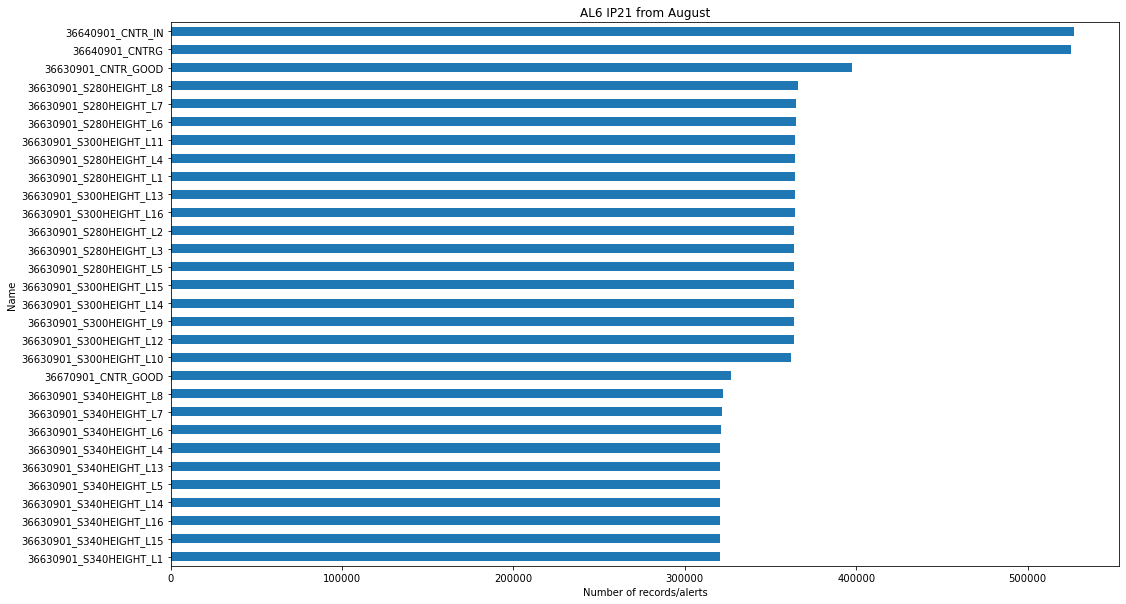

In [11]:
top30 = df_merge.groupby('Name')['IP_TREND_VALUE'].count().nlargest(30).sort_values(ascending=True)
top30.plot.barh(figsize=(17,10))
# plt.style.use('ggplot')
plt.title('AL6 IP21 from August')
plt.xlabel('Number of records/alerts')
plt.show()

In [12]:
len(df_merge.Name.unique())

173

In [13]:
# maybe we'll split into types of IP sensor?
df_height = df_merge[df_merge['Name'].str.contains('HEIGHT')]
df_cntr_good = df_merge[df_merge['Name'].str.contains('CNTR_GOOD')]
df_cntr_bad = df_merge[df_merge['Name'].str.contains('CNTR_BAD')]

In [14]:
df_height.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Name,15624458,64,36630901_S280HEIGHT_L8,365807,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_TREND_VALUE,15624458.0,61243.0,0.0,7666728.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_TREND_QLEVEL,15624458,2,Good,15624330,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_TREND_QSTATUS,15624458,2,Good,15624330,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Filename,15624458,64,tabIP21Data_36630901_S280HEIGHT_L8.csv,365807,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEFINITION,15624458,1,IP_AnalogAvDef,15624458,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_DESCRIPTION,15624458,4,AL6 HH: Höhenkontrolle S340 Lane,5123254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_STEPPED,15624458,1,Stepped,15624458,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_DC_SIGNIFICANCE,15624458.0,NaN,NaN,NaN,0.01,0.0,0.01,0.01,0.01,0.01,0.01
IP_VALUE_FORMAT,15624458,1,F 7. 2,15624458,NaN,NaN,NaN,NaN,NaN,NaN,NaN


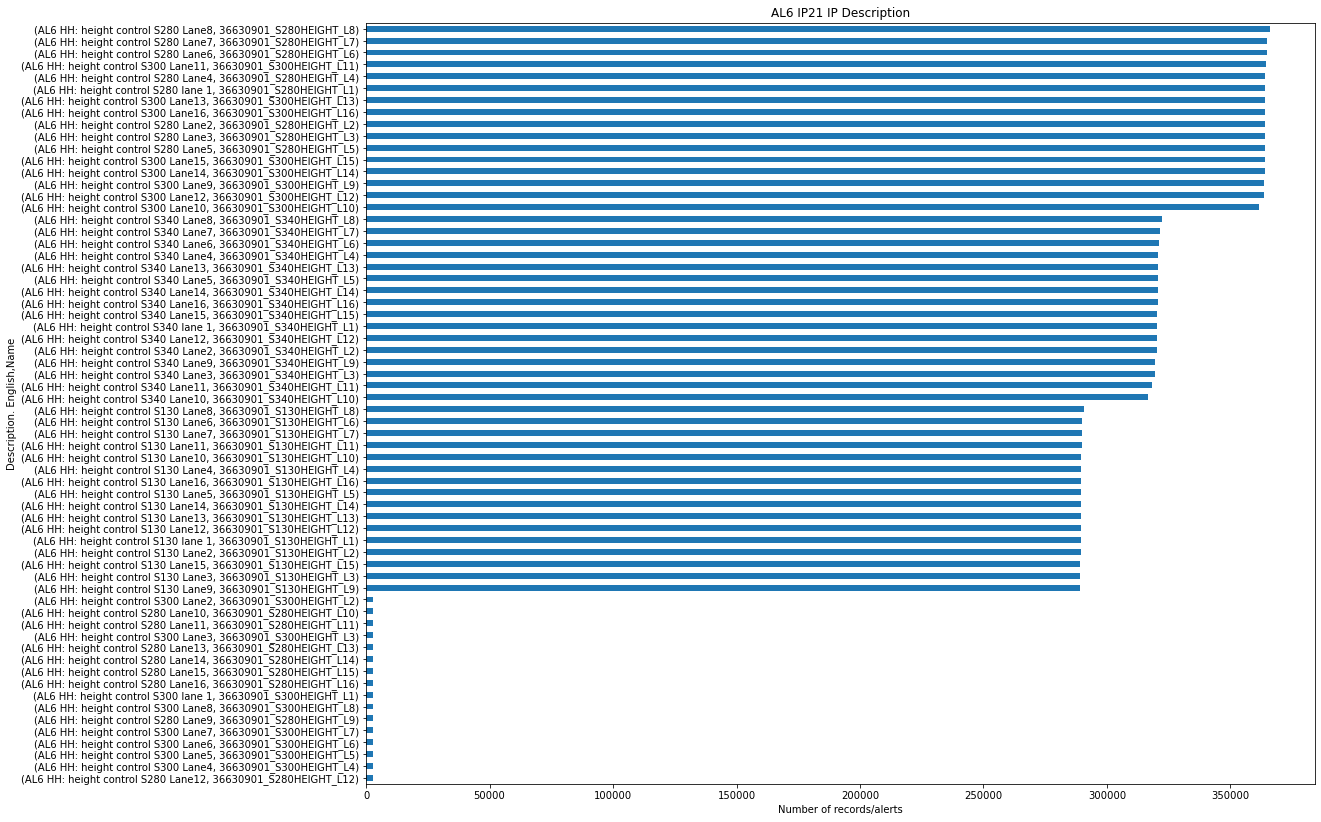

In [40]:
df_height.groupby(['Description. English'])['Name'].value_counts().sort_values(ascending=True).plot.barh(figsize=(17,14))
plt.title('AL6 IP21 IP Description')
plt.xlabel('Number of records/alerts')
plt.show()

In [39]:
df_height.groupby(['Description. English'])['IP_DC_SIGNIFICANCE'].describe()

,count,mean,std,min,25%,50%,75%,max
Description. English,,,,,,,,
AL6 HH: height control S130 Lane10,289592.0,0.01,5.797976e-14,0.01,0.01,0.01,0.01,0.01
AL6 HH: height control S130 Lane11,289838.0,0.01,5.811681e-14,0.01,0.01,0.01,0.01,0.01
AL6 HH: height control S130 Lane12,289415.0,0.01,5.788262e-14,0.01,0.01,0.01,0.01,0.01
AL6 HH: height control S130 Lane13,289442.0,0.01,5.789823e-14,0.01,0.01,0.01,0.01,0.01
AL6 HH: height control S130 Lane14,289450.0,0.01,5.790170e-14,0.01,0.01,0.01,0.01,0.01
...,...,...,...,...,...,...,...,...
AL6 HH: height control S340 Lane6,321176.0,0.01,7.374321e-14,0.01,0.01,0.01,0.01,0.01
AL6 HH: height control S340 Lane7,321436.0,0.01,7.386117e-14,0.01,0.01,0.01,0.01,0.01
AL6 HH: height control S340 Lane8,322181.0,0.01,7.419424e-14,0.01,0.01,0.01,0.01,0.01


In [16]:
df_cntr_good.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Name,1206206,6,36630901_CNTR_GOOD,397538,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_TREND_VALUE,1206206.0,441343.0,0.0,437.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_TREND_QLEVEL,1206206,2,Good,1206184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_TREND_QSTATUS,1206206,2,Good,1206184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Filename,1206206,6,tabIP21Data_36630901_CNTR_GOOD.csv,397538,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEFINITION,1206206,1,IP_DiscreteAvDef,1206206,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_DESCRIPTION,1206206,6,AL6 HH: Gutteile Gesamt,397538,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_STEPPED,1206206,1,Stepped,1206206,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_DC_SIGNIFICANCE,1206206.0,NaN,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0
IP_VALUE_FORMAT,1206206,1,I11,1206206,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
df_cntr_good.groupby(['Machine','Name'])['Name'].count()

Machine                            Name                  
BDIS Signale Endverpackung Pester  36680901_CNTR_GOOD         24526
                                   36680902_CNTR_GOOD         24246
BDIS Signale Montage HH            36630901_CNTR_GOOD        397538
                                   36630901_CNTR_GOOD_PCS    216549
                                   36630901_CNTR_GOOD_ZA     216354
BDIS Signale Single Unit SA        36670901_CNTR_GOOD        326993
Name: Name, dtype: int64

In [59]:
df_cntr_good.IP_TREND_VALUE = df_cntr_good.IP_TREND_VALUE.astype('int')

C:\Users\mark_\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [69]:
df_cntr_good.IP_TREND_VALUE.describe()

count    1.206206e+06
mean     1.634286e+05
std      3.390238e+06
min     -2.147353e+09
25%      4.352900e+04
50%      1.179235e+05
75%      2.678378e+05
max      6.193380e+05
Name: IP_TREND_VALUE, dtype: float64

In [87]:
df_cntr_bad.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Name,9380,2,36650901_CNTR_BAD_FS_SDM,4891,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_TREND_VALUE,9380.0,912.0,0.0,253.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_TREND_QLEVEL,9380,2,Good,9354,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_TREND_QSTATUS,9380,2,Good,9354,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Filename,9380,2,tabIP21Data_36650901_CNTR_BAD_FS_SDM.csv,4891,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEFINITION,9380,1,IP_DiscreteAvDef,9380,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_DESCRIPTION,9380,2,AL6 SCH: Schlechtteile SDM,4891,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_STEPPED,9380,1,Stepped,9380,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_DC_SIGNIFICANCE,9380.0,NaN,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0
IP_VALUE_FORMAT,9380,1,I11,9380,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
df_cntr_bad.groupby(['Machine','Name'])['Name'].count()

Machine                            Name                    
BDIS Signale Kartonierer Schubert  36650901_CNTR_BAD_FS_F2     4489
                                   36650901_CNTR_BAD_FS_SDM    4891
Name: Name, dtype: int64

In [90]:
df_cntr_bad.IP_TREND_VALUE = df_cntr_bad.IP_TREND_VALUE.astype('int')

C:\Users\mark_\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [92]:
df_cntr_bad.IP_TREND_VALUE.describe()

count    9380.000000
mean      231.910128
std       232.740033
min         0.000000
25%        51.000000
50%       163.000000
75%       338.000000
max      1203.000000
Name: IP_TREND_VALUE, dtype: float64

In [93]:
df_cntr_in = df_merge[df_merge.Name.str.contains('CNTR_IN')]

In [94]:
df_cntr_in.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Name,616761,2,36640901_CNTR_IN,527149,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_TREND_VALUE,616761.0,364995.0,147912.0,205.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_TREND_QLEVEL,616761,2,Good,616746,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_TREND_QSTATUS,616761,2,Good,616746,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Filename,616761,2,tabIP21Data_36640901_CNTR_IN.csv,527149,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEFINITION,616761,1,IP_DiscreteAvDef,616761,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_DESCRIPTION,616761,2,AL6 KRO:Zähler Gesamt Einlauf,527149,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_STEPPED,616761,1,Stepped,616761,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IP_DC_SIGNIFICANCE,616761.0,NaN,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0
IP_VALUE_FORMAT,616761,1,I11,616761,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
df_cntr_in.groupby(['Machine','Name'])['Name'].count()

Machine                            Name                
BDIS Signale Etikettierer Krones   36640901_CNTR_IN        527149
BDIS Signale Kartonierer Schubert  36650901_CNTR_INPUT1     89612
Name: Name, dtype: int64

Drop some columns that aren't needed for height files (no value added)

- IP_TREND_QLEVEL - always 'Good'   
- IP_TREND_QSTATUS - always 'Good'   
- DEFINITION - same info as IP_TAG_TYPE
- IP_STEPPED - always 'Stepped'
- IP_VALUE_FORMAT - can't see a need to know this
- IP_ENG_UNITS - always null
- IP_LOW_LIMIT - no values   
- IP_LOW_LOW_LIMIT - no values   
- IP_PLANT_AREA - always 'AL6'   
- IP_REPOSITORY - always 'TSK_DHIS_SFD'   

In [80]:
df_startend = df_merge[df_merge.Name.str.contains('STARTEND')]

In [86]:
df_startend.sort_index

<bound method DataFrame.sort_index of                                       Name IP_TREND_VALUE IP_TREND_QLEVEL  \
IP_TREND_TIME                                                               
2021-08-19 20:09:50.700  36680901_STARTEND              0            Good   
2021-08-19 19:59:51.100  36680901_STARTEND              0            Good   
2021-08-19 19:49:51.200  36680901_STARTEND              0            Good   
2021-08-19 19:39:52.100  36680901_STARTEND              0            Good   
2021-08-19 19:29:52.800  36680901_STARTEND              0            Good   
...                                    ...            ...             ...   
2021-08-01 00:42:58.700  36680902_STARTEND              0            Good   
2021-08-01 00:32:59.600  36680902_STARTEND              0            Good   
2021-08-01 00:23:00.200  36680902_STARTEND              0            Good   
2021-08-01 00:13:01.100  36680902_STARTEND              0            Good   
2021-08-01 00:03:01.300  36680902_STAR

In [98]:
# get the alarms.csv we produced earlier, which will say which ones are significant
filename = 'alarms.csv'
folder = 'IP21'
path = os.path.join(dir_local, folder, filename)
# parse_dates and index datafram
df_alarms = pd.read_csv(path, encoding='UTF-8', index_col='Start', dayfirst=True)
df_alarms.index = pd.to_datetime(df_alarms.index,dayfirst=True)
df_alarms.sort_index(inplace=True)
df_alarms.drop(['Unnamed: 0'], axis=1, inplace=True)


In [100]:
#Define start and end date for August

start_date = '2021-08-01'
end_date = '2021-09-01'

days = datetime.strptime(end_date, '%Y-%m-%d')-datetime.strptime(start_date, '%Y-%m-%d')
# think this needs to be +1 day now that date filter is inclusive of end_date
ndays=days.days+1

df_alarms = df_alarms[(df_alarms.index >= start_date) & (df_alarms.index <= end_date) ]

# this throws a warning if the dates being used are not in the index, so not using it as this will be an error in future editions
# df_dates = df.loc[[start_date:end_date]


# df_dates=df_dates[df_dates['Filename'].str.contains(machine)]

In [45]:
df_merge['Machine'].unique()

array(['BDIS Signale Montage HH', 'BDIS Signale Etikettierer Krones',
       'BDIS Signale Kartonierer Schubert', 'BDIS Signale Single Unit SA',
       'BDIS Signale Endverpackung Pester'], dtype=object)

In [97]:
df_merge.head()

,Name,IP_TREND_VALUE,IP_TREND_QLEVEL,IP_TREND_QSTATUS,Filename,DEFINITION,IP_DESCRIPTION,IP_STEPPED,IP_DC_SIGNIFICANCE,IP_VALUE_FORMAT,IP_ENG_UNITS,IP_HIGH_HIGH_LIMIT,IP_HIGH_LIMIT,IP_LOW_LIMIT,IP_LOW_LOW_LIMIT,IP_PLANT_AREA,IP_REPOSITORY,IP_TAG_TYPE,Machine,Description. English
IP_TREND_TIME,,,,,,,,,,,,,,,,,,,,
2021-08-19 20:09:55.900,36630901_BATCHACTIVE,-1,Good,Good,tabIP21Data_36630901_BATCHACTIVE.csv,IP_DiscreteAvDef,AL6 HH: Batch aktiv,Stepped,1.0,I 2,-,2,2,0.0,0.0,AL6,TSK_DHIS_SFD,Discrete,BDIS Signale Montage HH,AL6 HH: Batch active
2021-08-19 19:59:56.200,36630901_BATCHACTIVE,-1,Good,Good,tabIP21Data_36630901_BATCHACTIVE.csv,IP_DiscreteAvDef,AL6 HH: Batch aktiv,Stepped,1.0,I 2,-,2,2,0.0,0.0,AL6,TSK_DHIS_SFD,Discrete,BDIS Signale Montage HH,AL6 HH: Batch active
2021-08-19 19:49:56.300,36630901_BATCHACTIVE,-1,Good,Good,tabIP21Data_36630901_BATCHACTIVE.csv,IP_DiscreteAvDef,AL6 HH: Batch aktiv,Stepped,1.0,I 2,-,2,2,0.0,0.0,AL6,TSK_DHIS_SFD,Discrete,BDIS Signale Montage HH,AL6 HH: Batch active
2021-08-19 19:39:57.200,36630901_BATCHACTIVE,-1,Good,Good,tabIP21Data_36630901_BATCHACTIVE.csv,IP_DiscreteAvDef,AL6 HH: Batch aktiv,Stepped,1.0,I 2,-,2,2,0.0,0.0,AL6,TSK_DHIS_SFD,Discrete,BDIS Signale Montage HH,AL6 HH: Batch active
2021-08-19 19:29:58.000,36630901_BATCHACTIVE,-1,Good,Good,tabIP21Data_36630901_BATCHACTIVE.csv,IP_DiscreteAvDef,AL6 HH: Batch aktiv,Stepped,1.0,I 2,-,2,2,0.0,0.0,AL6,TSK_DHIS_SFD,Discrete,BDIS Signale Montage HH,AL6 HH: Batch active


In [108]:
# I think this is creating a merged dataframe of all IP21 data 5m either side of a significant alarm
df_alarms = df_alarms.sort_index()
df_height = df_height.sort_index()
df_alarms_ip21 = pd.merge_asof(df_height, df_alarms, left_index=True, right_index=True, allow_exact_matches=True, tolerance=pd.Timedelta("5m"))

In [112]:
df_significant_alarms_ip21 = df_alarms_ip21[df_alarms_ip21.Significant == 'Yes']

In [269]:
# df_significant_alarms_ip21.info()
df_significant_alarms_ip21.groupby([pd.Grouper(freq='D'),'Description. English','Message Text (English)','Machine_x'])['IP_TREND_VALUE'].count().sample(30)



IP_TREND_TIME  Description. English                Message Text (English)                                                               Machine_x              
2021-08-07     AL6 HH: height control S340 Lane4   Camera (SDM): evaluation outside test time                                           BDIS Signale Montage HH     754
2021-08-01     AL6 HH: height control S340 Lane15  F2_204 # recording error (= D + R1-Ex-E92-SV3)                                       BDIS Signale Montage HH       2
2021-08-05     AL6 HH: height control S340 Lane6   Device jam in the outlet                                                             BDIS Signale Montage HH     605
2021-08-17     AL6 HH: height control S340 Lane3   GMP: Malfunction, subsequent error: Code control unit 1                              BDIS Signale Montage HH      25
2021-08-19     AL6 HH: height control S130 Lane8   Device missing from device recognition step chain track 3 (= D + EXT-26BBL4)         BDIS Signale Montage HH      26


In [207]:
# drop data between 22:00 on Sat through to 06:00 on Monday, as Sunday is closed on AL6
# get Tues - fri data first
df_significant_alarms_ip21_no_sunday = df_significant_alarms_ip21[(df_significant_alarms_ip21.index.dayofweek > 0) & (df_significant_alarms_ip21.index.dayofweek < 5)]


In [208]:
# get Mon between 06:00 and 23:59
df_mon = df_significant_alarms_ip21[df_significant_alarms_ip21.index.dayofweek == 0]
df_mon = df_mon.between_time('06:00', '23:59')
df_significant_alarms_ip21_no_sunday = df_significant_alarms_ip21_no_sunday.append(df_mon)

# get saturday between 00:00 and 22:00
df_sat = df_significant_alarms_ip21[df_significant_alarms_ip21.index.dayofweek == 5]
df_sat = df_sat.between_time('00:00', '22:00')
df_significant_alarms_ip21_no_sunday = df_significant_alarms_ip21_no_sunday.append(df_sat)

In [210]:
df_aug_07 = df_significant_alarms_ip21_no_sunday.loc['2021-08-07']

<AxesSubplot:title={'center':'IP_TREND_VALUE from IP21 data'}, xlabel='IP_TREND_TIME'>

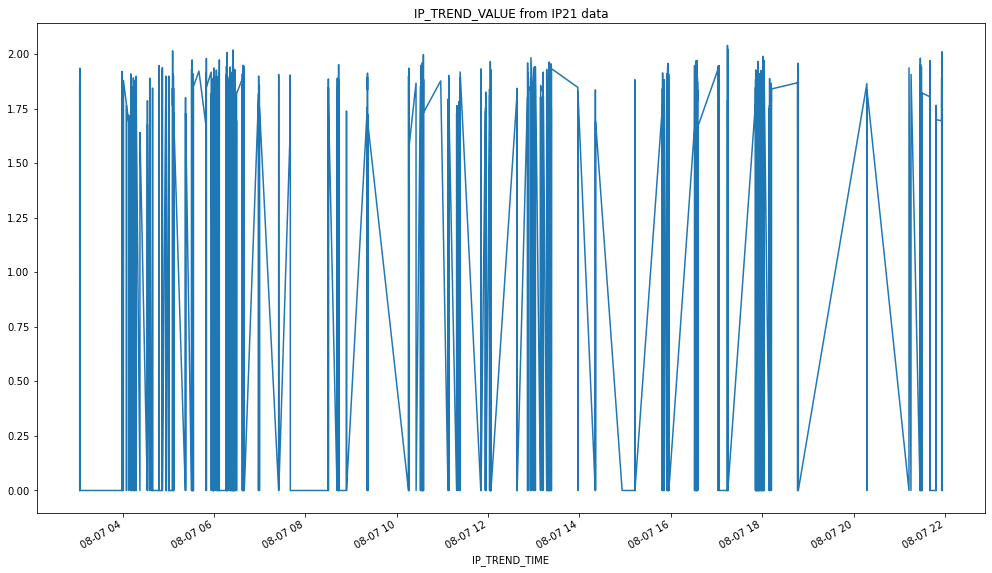

In [233]:
df_aug_07[(df_aug_07.Name == '36630901_S130HEIGHT_L10') & (df_aug_07.Duration.isnull() == False)]['IP_TREND_VALUE'].plot(figsize=(17,10), title='IP_TREND_VALUE from IP21 data')

<AxesSubplot:title={'center':'Duration from Alarms'}, xlabel='IP_TREND_TIME'>

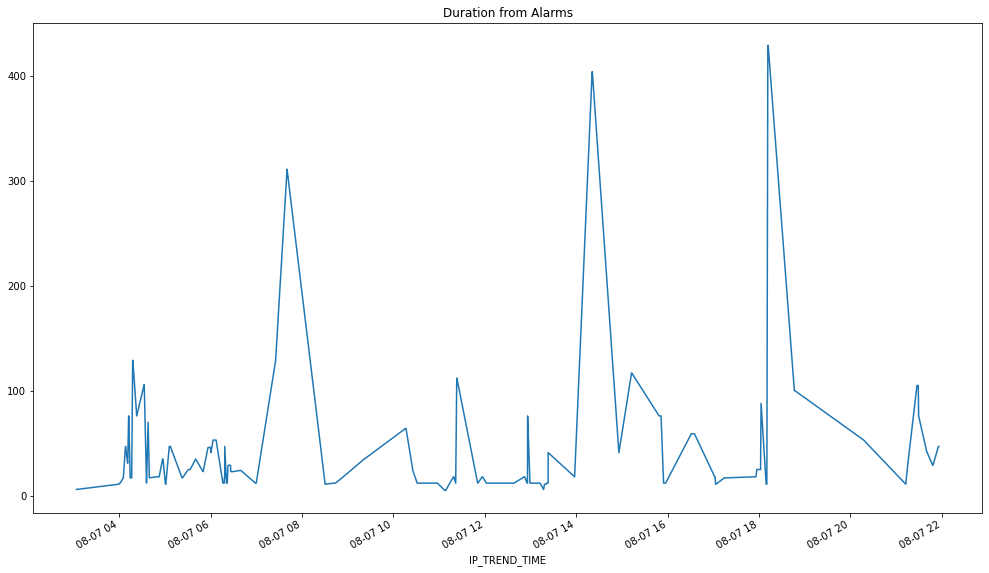

In [232]:
df_aug_07[(df_aug_07.Name == '36630901_S130HEIGHT_L10') & (df_aug_07.Duration.isnull() == False)]['Duration'].plot(figsize=(17,10), title='Duration from Alarms')

In [267]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
data = df_aug_07[df_aug_07.Duration.isnull() == False][['Duration','IP_TREND_VALUE']]
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

<AxesSubplot:title={'center':'Alarms Duration and IP21 TREND_VALUE'}, xlabel='IP_TREND_TIME'>

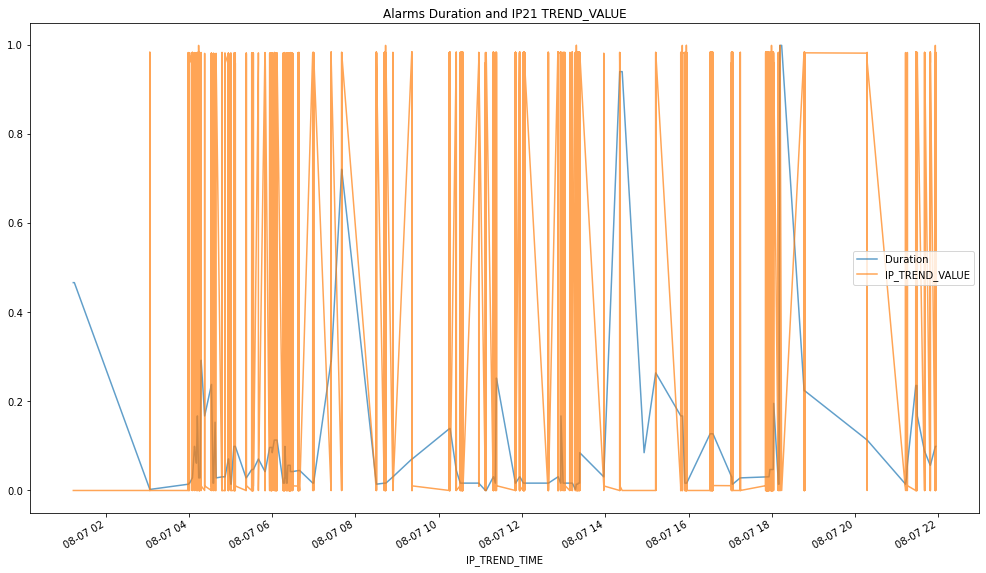

In [268]:
data_scaled.plot(figsize=(17,10), alpha=0.7, title='Alarms Duration and IP21 TREND_VALUE')